In [10]:
import torch
import cv2 as cv
import os
import pandas as pd
import shutil
from PIL import Image
import matplotlib.pyplot as plt


YOLOv5 🚀 v7.0-416-gfe1d4d99 Python-3.10.12 torch-2.6.0+cu124 CPU

Fusing layers... 
Model summary: 157 layers, 1764577 parameters, 0 gradients, 4.1 GFLOPs
Adding AutoShape... 
/home/mircea/Documents/hobbies/proiectePersonale/bike-system/detect-signs/deep-learning/yolov5/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
image 1/1: 960x1280 1 give-way
Speed: 2.0ms pre-process, 28.9ms inference, 0.5ms NMS per image at shape (1, 3, 480, 640)


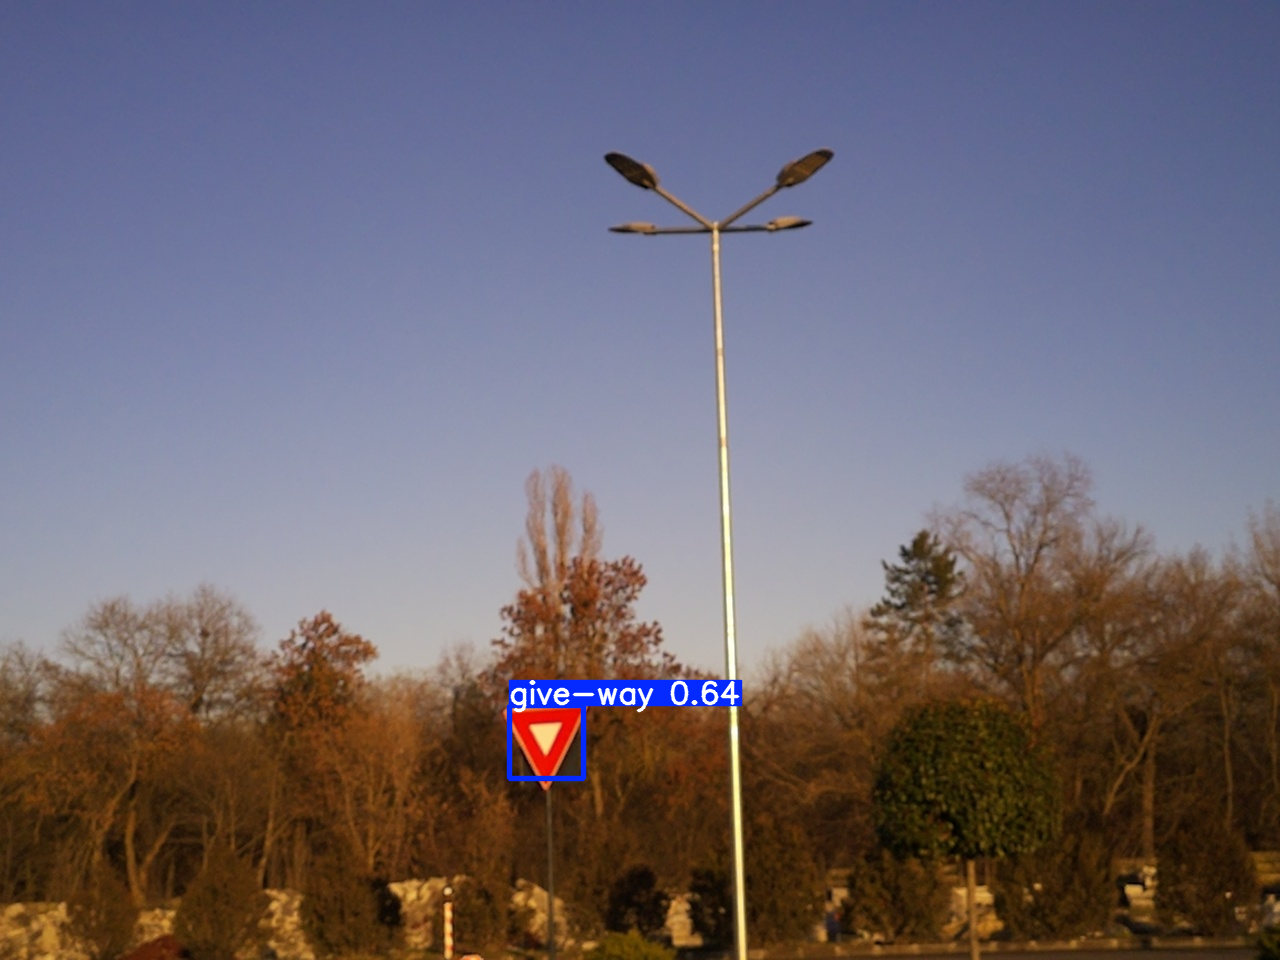

Saved 1 image to runs/detect/exp49


In [43]:

def model_eg():
    # Load a YOLOv5 model (options: yolov5n, yolov5s, yolov5m, yolov5l, yolov5x)
    # model = torch.hub.load("ultralytics/yolov5", "yolov5n")  # Default: yolov5s
    model = torch.hub.load('yolov5', 'custom', path='./yolov5/runs/train/yolov5n-640-b8-e5-full-de3/weights/last.pt', source='local')

    # Define the input image source (URL, local file, PIL image, OpenCV frame, numpy array, or list)
    img = cv.imread("test_images/small.jpg", cv.IMREAD_COLOR)  # Example image
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    # Perform inference (handles batching, resizing, normalization automatically)
    results = model(img)

    # Process the results (options: .print(), .show(), .save(), .crop(), .pandas())
    results.print()  # Print results to console
    results.show()  # Display results in a window
    results.save()  # Save results to runs/detect/exp

model_eg()

## Getting the dataset ready

In [12]:
GTSRB_path = "./GTSRB/"
whole_img_dataset = "./GTSDB/"

train_img_path = "./dataset/images/train"
val_img_path = "dataset/images/val"
train_lbl_path = "./dataset/labels/train"
val_lbl_path = "dataset/labels/val"

train_val_split = 0.8

In [13]:
line = "00001.ppm;973;335;1031;390;13"
line = line.split(";")
for i in range(len (line)):
    if i != 0:
        line[i] = int(line[i])

p1 = (line[1], line[2])
p2 = (line[3], line[4])
thickness = 6
color = (255, 0, 0)

img = cv.imread(os.path.join(whole_img_dataset, "00001.ppm"), cv.IMREAD_COLOR)
cv.rectangle(img, p1, p2, color, thickness)

plt.imshow(img)

In [14]:
def delete_dataset():
    folders = [train_img_path, val_img_path, train_lbl_path, val_lbl_path]
    for folder in folders:
        print("deleting from:", folder)
        for filename in os.listdir(folder):
            file_path = os.path.join(folder, filename)
            if os.path.isfile(file_path):
                os.remove(file_path)

delete_dataset()

deleting from: ./dataset/images/train
deleting from: dataset/images/val
deleting from: ./dataset/labels/train
deleting from: dataset/labels/val


In [15]:
def convert_sign_dir_to_YOLO(dir, class_id):
    path = os.path.join(GTSRB_path, dir)
    csv_file_name = [file for file in os.listdir(path) if file.endswith(".csv")][0]
    csv_file_name = os.path.join(path, csv_file_name)

    df = pd.read_csv(csv_file_name, sep=";")
    # shuffle df
    df = df.sample(frac=1).reset_index(drop=True)

    # Filename    Width       Height     Roi.X1    Roi.Y1   Roi.X2  Roi.Y2 ClassId
    for index, row in df.iterrows():
        # copy img
        img_path = train_img_path
        lbl_path = train_lbl_path
        if index / len(df) > train_val_split:
            img_path = val_img_path
            lbl_path = val_lbl_path

        src_img_filename = row["Filename"]
        dst_img_filename = str(class_id) + "_" + src_img_filename
        dst_img_filename = dst_img_filename.replace('.ppm', '.png')

        img_src_path = os.path.join(path, src_img_filename)
        img_dst_path = os.path.join(img_path, dst_img_filename)

        img = Image.open(img_src_path)
        img.save(img_dst_path, "PNG")

        img_width = row["Width"]
        img_height = row["Height"]
        x1 = row["Roi.X1"]
        y1 = row["Roi.Y1"]
        x2 = row["Roi.X2"]
        y2 = row["Roi.Y2"]

        # convert to yolo
        x_center = ((x1 + x2) / 2) / img_width
        y_center = ((y1 + y2) / 2) / img_height
        bbox_width = (x2 - x1) / img_width
        bbox_height = (y2 - y1) / img_height

        label_filename = dst_img_filename.replace('.png', '.txt')
        label_path = os.path.join(lbl_path, label_filename)
        with open(label_path, 'w') as f:
            f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}\n")

convert_sign_dir_to_YOLO("00013-give-way", 0)
convert_sign_dir_to_YOLO("00014-stop", 1)
convert_sign_dir_to_YOLO("00017-no-entry", 2)
convert_sign_dir_to_YOLO("00018-warning", 3)

In [16]:
def convert_GTSDB_to_YOLO(path):
    whole_img_idx = 12
    classes = [13, 14, 17, 18]

    csv_file_name = [file for file in os.listdir(path) if file.endswith(".csv")][0]
    csv_file_name = os.path.join(path, csv_file_name)

    df = pd.read_csv(csv_file_name, sep=";")
    # shuffle df
    df = df.sample(frac=1).reset_index(drop=True)

    # img; leftCol; topRow; rightCol; bottomRow; class
    for index, row in df.iterrows():
        class_id = row["class"]
        if(class_id not in classes):
            continue
        
        # copy img
        img_path = train_img_path
        lbl_path = train_lbl_path
        if index / len(df) > train_val_split:
            img_path = val_img_path
            lbl_path = val_lbl_path

        src_img_filename = row["img"]
        dst_img_filename = str(whole_img_idx) + "_" + str(classes.index(class_id)) + "_" + src_img_filename
        dst_img_filename = dst_img_filename.replace('.ppm', '.png')

        img_src_path = os.path.join(path, src_img_filename)
        img_dst_path = os.path.join(img_path, dst_img_filename)

        img = Image.open(img_src_path)
        img_width, img_height = img.size
        img.save(img_dst_path, "PNG")

        x1 = row["leftCol"]
        y1 = row["topRow"]
        x2 = row["rightCol"]
        y2 = row["bottomRow"]


        # convert to yolo
        x_center = ((x1 + x2) / 2) / img_width
        y_center = ((y1 + y2) / 2) / img_height
        bbox_width = (x2 - x1) / img_width
        bbox_height = (y2 - y1) / img_height

        label_filename = dst_img_filename.replace('.png', '.txt')
        label_path = os.path.join(lbl_path, label_filename)
        with open(label_path, 'w') as f:
            f.write(f"{classes.index(class_id)} {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}\n")

convert_GTSDB_to_YOLO(whole_img_dataset)